# Emotional State Classifier on a multimodal physiological Dataset.

### Sina Dabiri
### sdabiri3@gatech.edu, sdabiri@emory.edu
### Version 1.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys
import mne
import time
import pickle
import argparse

In [3]:
from mne.preprocessing import ICA, create_eog_epochs
from scipy.stats import skew, kurtosis
from scipy.signal import argrelextrema
import heartpy as hp
import pprint

In [4]:
pwd

'C:\\Users\\sinad\\OneDrive - Georgia Institute of Technology\\BMED 6517 ML Biosci\\Project\\emotional_state_classifier\\BMED_6517_emotional_state_classifier'

### 1: Preprocessing

In [5]:
# Setting the path for root directory for DEAP dataset, data folder, participants ratings, and EEG channel lists

root_folder = 'C:\\Users\\sinad\OneDrive - Georgia Institute of Technology\\BMED 6517 ML Biosci\\Project\\emotional_state_classifier\\DEAP\\DEAP'
data_folder = root_folder + '\data_original'
ratings_csv_path = root_folder + '\Metadata\metadata_csv\participant_ratings.csv'
DEAP_EEG_channels_xlsx_path = root_folder + '\Metadata\DEAP_EEG_channels.xlsx'

In [6]:
npy_folder = os.path.join(os.getcwd(), 'results', 'npy')
print(npy_folder)

for folder in [npy_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\npy


In [7]:
N_trials = 40
N_EEG_electrodes = 32
N_BIPOLAR = 16
sfreq = 128

In [58]:
def epoch_bdf(subject_id):
    npy_plet_path = os.path.join(npy_folder, 's{:02}_plet.npy'.format(subject_id))
    npy_GSR_path = os.path.join(npy_folder, 's{:02}_GSR.npy'.format(subject_id))
    npy_EOG_path = os.path.join(npy_folder, 's{:02}_EOG.npy'.format(subject_id))
    npy_EMG_path = os.path.join(npy_folder, 's{:02}_EMG.npy'.format(subject_id))

    print('\n----------------------------------------------------\n')
    print('extracting bipolar data for Subject {:02}'.format(subject_id))

    bdf_file_name = 's{:02d}.bdf'.format(subject_id)
    bdf_file_path = os.path.join(data_folder, bdf_file_name)

    print('Loading .bdf file {}'.format(bdf_file_path))
    raw = mne.io.read_raw_bdf(bdf_file_path, preload=True, verbose=False).load_data()

    ch_names = raw.ch_names
    eeg_channels = ch_names[:N_EEG_electrodes]
    non_eeg_channels = ch_names[N_EEG_electrodes:]
    stim_ch_name = ch_names[-1]
    stim_channels = [ stim_ch_name ]

    raw_copy = raw.copy()
    raw_stim = raw_copy.pick_channels(stim_channels)
    raw.pick_channels(non_eeg_channels)
    print("Done!")

    #####################################################
    print('Getting events from the status channel')
    events = mne.find_events(raw_stim, stim_channel=stim_ch_name, verbose=True)
    if subject_id<=23:
        # Subject 1-22 and Subjects 23-28 have 48 channels.
        # Subjects 29-32 have 49 channels.
        # For Subjects 1-22 and Subject 23, the stimuli channel has the name 'Status'
        # For Subjects 24-28, the stimuli channel has the name ''
        # For Subjects 29-32, the stimuli channels have the names '-0' and '-1'
        pass
    else:
        # The values of the stimuli channel have to be changed for Subjects 24-32
        # Trigger channel has a non-zero initial value of 1703680 (consider using initial_event=True to detect this event)
        events[:,2] -= 1703680 # subtracting initial value
        events[:,2] = events[:,2] % 65536 # getting modulo with 65536

    print('')
    event_IDs = np.unique(events[:,2])
    for event_id in event_IDs:
        col = events[:,2]
        print('Event ID {} : {:05}'.format(event_id, np.sum( 1.0*(col==event_id) ) ) )
    inds_new_trial = np.where(events[:,2] == 4)[0]
    events_new_trial = events[inds_new_trial,:]
    baseline = (0, 0)
    print('Epoching the data, into [-5sec, +60sec] epochs')
    epochs = mne.Epochs(raw, events_new_trial, event_id=4, tmin=-5.0, tmax=60.0, picks=non_eeg_channels, baseline=baseline, preload=True)

    
    epochs_copy = epochs.copy()
    print('Downsampling epoched data to 128 Hz')
    epochs_downsampled = epochs_copy.resample(sfreq)

    data = epochs.get_data()
    data_downsampled = epochs_downsampled.get_data()
    print('Original epoched data shape: {}'.format(data.shape))
    print('Downsampled epoched data shape: {}'.format(data_downsampled.shape))

    #############################

    ratings = pd.read_csv(ratings_csv_path)
    is_subject =  (ratings['Participant_id'] == subject_id)
    ratings_subj = ratings[is_subject]
    trial_pick_indices = []
    print('\nPreparing EEG trial reordering, from presentation order, to video (Experiment_id) order')
    for i in range(N_trials):
        exp_id = i+1
        is_exp = (ratings['Experiment_id'] == exp_id)
        trial_id = ratings_subj[is_exp]['Trial'].values[0]
        trial_pick_indices.append(trial_id - 1)
        print('Picking source (raw) trial #{:02} to fill target (npy) trial #{:02} | Experiment_id: {:02}'.format(trial_id, exp_id, exp_id))

    #############################    

    # Store clean and reordered data to numpy array
    epoch_duration = data_downsampled.shape[-1]
    data_npy = np.zeros((N_trials, N_BIPOLAR, epoch_duration))
    print(data_npy.shape)
    print('\nStoring the final EEG data in a numpy array of shape {}'.format(data_npy.shape))
    print(len(trial_pick_indices))
    for trial_source, trial_target in zip(trial_pick_indices, range(N_trials)):
        data_trial = data_downsampled[trial_source]
        # print(data_trial.shape)
        # print(data_npy[trial_target,:,:].shape)
        data_npy[trial_target,:,:] = data_trial.copy()
    print('Saving the final EEG data in a .npy file')
    np.save(npy_plet_path, data_npy[:,13,:])
    np.save(npy_GSR_path, data_npy[:,8,:])
    np.save(npy_EOG_path, data_npy[:,0:4,:])
    np.save(npy_EMG_path, data_npy[:,4:8,:])

    print('Raw physiological data has been epoched, downsampled, trial-reordered and channel-reordered.')
    print('Finished.') 
    return raw, epochs, epochs_downsampled, data_npy, ratings_subj

In [59]:
subject_id = 24

raw, epochs, epochs_downsampled, data_npy,ratings_subj = epoch_bdf(subject_id)


----------------------------------------------------

extracting bipolar data for Subject 24
Loading .bdf file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\DEAP\DEAP\data_original\s24.bdf
Done!
Getting events from the status channel
Trigger channel has a non-zero initial value of 1703680 (consider using initial_event=True to detect this event)
296 events found
Event IDs: [1638145 1638146 1638147 1638148 1638149 1638151]

Event ID 1 : 168.0
Event ID 2 : 004.0
Event ID 3 : 041.0
Event ID 4 : 040.0
Event ID 5 : 042.0
Event ID 7 : 001.0
Epoching the data, into [-5sec, +60sec] epochs
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 33281 original time points ...
0 bad epochs dropped
Downsampling epoched data to 128 Hz
Original epoched data shape: (40, 16, 33281)
Downsampled epoched data shape: (40, 16, 8320)


C:\Users\sinad\AppData\Local\Temp\ipykernel_8396\1338917678.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_id = ratings_subj[is_exp]['Trial'].values[0]


Raw physiological data has been epoched, downsampled, trial-reordered and channel-reordered.
Finished.


In [60]:
print(raw.describe())

<RawEDF | s24.bdf, 16 x 2412544 (4712.0 s), ~294.5 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  EXG1  EEG   µV     17170.39   22212.13   27428.39   32011.74   35409.61
 1  EXG2  EEG   µV      5018.29    9387.31   13376.37   16514.86   19895.14
 2  EXG3  EEG   µV    -13894.71   -8925.48   -4658.05   -1071.76    9042.28
 3  EXG4  EEG   µV    -11975.81   -7730.10   -4561.44   -1288.47    2101.76
 4  EXG5  EEG   µV    -18051.67  -15930.83  -13475.26  -10033.68   -6863.88
 5  EXG6  EEG   µV    -14584.24  -11144.40   -8775.91   -5499.81   -2684.42
 6  EXG7  EEG   µV    -17529.70  -15705.64  -13472.52  -10539.27   -4247.13
 7  EXG8  EEG   µV    -19604.10  -15303.30  -11425.99   -6971.03   -2557.45
 8  GSR1  EEG   µV    64437396560.04  72216194686.78  74389565670.94  76580374122.88  86366043541.43
 9  GSR2  EEG   µV    -140625.66  1765620.81  2296869.83  2890618.73  10296855.05
10  Erg1  EEG   µV       -55.12     -45.87     -44.62     -43.37 

In [61]:
print(raw.ch_names)

['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp', '']


In [64]:
print(ratings_subj, ratings_subj.dtypes)

     Participant_id  Trial  Experiment_id  Start_time  Valence  Arousal  \
920              24      1             19     2942276     7.03     5.05   
921              24      2             17     3843296     4.08     5.99   
922              24      3             23     4888772     1.00     8.06   
923              24      4             20     5893417     4.03     6.08   
924              24      5             22     6840282     3.03     6.06   
925              24      6             27     7788618     6.08     5.03   
926              24      7             18     9172970     8.96     7.00   
927              24      8             30    10188472     1.00     8.03   
928              24      9              6    11243454     5.96     5.99   
929              24     10             26    12168300     4.05     6.99   
930              24     11             21    13218999     1.96     8.05   
931              24     12              2    14268406     6.04     6.09   
932              24     1

### 2. Feature extraction: 

In [12]:
def statistics_feature(data):
    mean = np.mean(data)
    std = np.std(data)
    Skew = skew(data)
    kurt = kurtosis(data)
    mean_fst_absdiff = np.mean(abs(np.diff(data)))
    mean_snd_absdiff = np.mean(abs(np.diff(np.diff(data))))
    mean_fst_diff = np.mean(np.diff(data))
    mean_snd_diff = np.mean(np.diff(np.diff(data)))
    mean_neg_diff = np.mean(np.diff(data)[np.where(np.diff(data)<0)])
    proportion_neg_diff = len(np.where(np.diff(data)<0)[0])/(len(np.diff(data)))
    number_local_min = len(argrelextrema(data,np.less)[0])
    number_local_max = len(argrelextrema(data,np.greater)[0])
    f1 = [mean,std,Skew,kurt]
    f2 = [mean_fst_absdiff,mean_snd_absdiff,mean_fst_diff,mean_snd_diff,mean_neg_diff,proportion_neg_diff]
    f3 = [number_local_min,number_local_max]
    f = f1+f2+f3
    names = ['mean','std','skew','kurtosis','me.1absdf','me.2absdf','me.1df','me.2df','me.negdf','ro.negdf','num.argmi','num.argma']
    GSR_features = dict(zip(names, f))
    return GSR_features

#### 2.1: Heart Rate and GSR:

In [13]:
def extract_HR_features(subject_id,trial_num):

    trial = trial_num

    feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')

    plet_path = os.path.join(feats_folder, 's{:02}_plet.npy'.format(subject_id))
    if os.path.exists(plet_path):
        print('\nFeatures are already saved.\nSkipping data extraction for Subject {:02}'.format(subject_id))

    print('\nExtracting features for Subject {:02}'.format(subject_id))

    # Load data
    plet_file_path = os.path.join(npy_folder, 's{:02d}_plet.npy'.format(subject_id))
    print('Loading preprocessed Plethysmograph from .npy file {}\n'.format(plet_path))
    plet_data = np.load(plet_file_path)

    wd, m = hp.process(plet_data[trial,:], sample_rate = sfreq)

    # set large figure
    # plt.figure(figsize=(7,4))

    # call plotter
    hp.plotter(wd, m, figsize=(7,3))
    plt.show()
    
    return m


Extracting features for Subject 24
Loading preprocessed Plethysmograph from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s24_plet.npy



C:\Users\sinad\anaconda3\envs\MLclass_EmotionalState_env\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


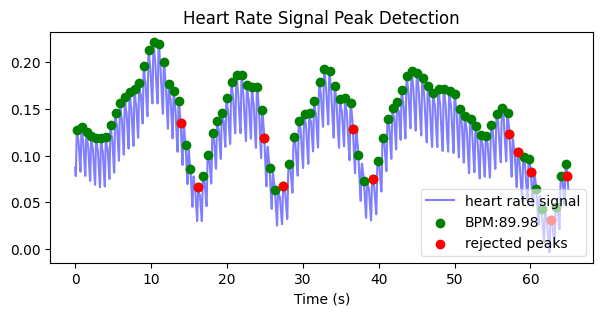

bpm: 89.981741
ibi: 666.801948
sdnn: 36.049951
sdsd: 18.895683
rmssd: 30.287775
pnn20: 0.522388
pnn50: 0.104478
hr_mad: 31.250000
sd1: 21.346583
sd2: 45.248247
s: 3034.450037
sd1/sd2: 0.471766
breathingrate: 0.133333


In [14]:
trial_num = 1

HR_feat = extract_HR_features(subject_id, trial_num)
for measure in HR_feat.keys():
    print('%s: %f' %(measure, HR_feat[measure]))

In [15]:
def extract_GSR_features(subject_id,trial_num):

    trial = trial_num

    feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')

    GSR_path = os.path.join(feats_folder, 's{:02}_GSR.npy'.format(subject_id))
    if os.path.exists(GSR_path):
        print('\nFeatures are already saved.\nSkipping data extraction for Subject {:02}'.format(subject_id))

    print('\nExtracting features for Subject {:02}'.format(subject_id))

    # Load data
    GSR_file_path = os.path.join(npy_folder, 's{:02d}_GSR.npy'.format(subject_id))
    print('Loading preprocessed GSR from .npy file {}\n'.format(GSR_path))
    GSR_data = np.load(GSR_file_path)
    
    plt.figure(figsize=(7,3))
    plt.plot(GSR_data[trial,:])
    plt.show()
    
    features = statistics_feature(GSR_data)
    return features



Extracting features for Subject 24
Loading preprocessed GSR from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s24_GSR.npy



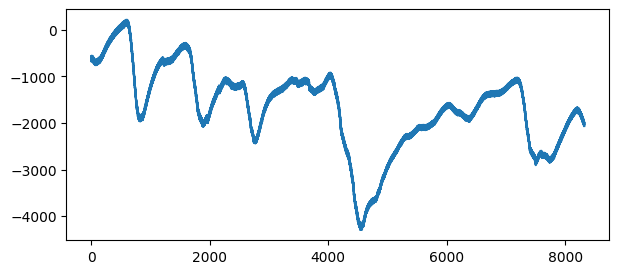

mean:  1070.3267617751926
std:  2006.310568280684
skew:  [1.88186571 1.89012933 1.85936534 ... 0.32140903 0.34282464 0.31856482]
kurtosis:  [ 3.45771985  3.5511357   3.36295244 ... -0.76459735 -0.71991634
 -0.74024196]
me.1absdf:  74.07927631752688
me.2absdf:  138.6191386898667
me.1df:  0.11703658818892068
me.2df:  0.0016441191909007844
me.negdf:  -74.06105902916048
ro.negdf:  4153.95
num.argmi:  107868
num.argma:  104653


In [16]:
gsr_feat = extract_GSR_features(subject_id, trial_num)
#pprint.pprint(gsr_feat)

for measure in gsr_feat.keys():
    print('%s: ' %(measure),gsr_feat[measure])

#### 2.2: EEG

In [34]:
from mne.preprocessing import ICA, create_eog_epochs

In [35]:
root_folder = 'C:/Users/sinad/OneDrive - Georgia Institute of Technology/BMED 6517 ML Biosci/Project/emotional_state_classifier/DEAP/DEAP/data_original'
ratings_csv_path = 'C:/Users/sinad/OneDrive - Georgia Institute of Technology/BMED 6517 ML Biosci/Project/emotional_state_classifier/DEAP/DEAP/Metadata/metadata_csv/participant_ratings.csv' # os.path.join(os.getcwd(), 'metadata_csv', 'participant_ratings.csv')
DEAP_EEG_channels_xlsx_path = 'C:/Users/sinad/OneDrive - Georgia Institute of Technology/BMED 6517 ML Biosci/Project/emotional_state_classifier/DEAP/DEAP/Metadata/DEAP_EEG_channels.xlsx'

In [36]:
N_trials = 40
N_EEG_electrodes = 32
N_ICA = N_EEG_electrodes - 1

In [37]:
ICA_components_folder = os.path.join(os.getcwd(), 'results', 'ICA_components')
ICA_models_folder = os.path.join(os.getcwd(), 'results', 'ICA_models')
PSD_folder = os.path.join(os.getcwd(), 'results', 'PSD')
mneraw_as_pkl_folder = os.path.join(os.getcwd(), 'results', 'pkl')
npy_folder = os.path.join(os.getcwd(), 'results', 'npy')

In [38]:
if __name__=='__main__':
	parser = argparse.ArgumentParser(description="Preprocessing the DEAP dataset's .bdf files")
	parser.add_argument('--subject_id', type=int, default=1, help="Subject ID")
	args = parser.parse_args()

	clean_bdf(args.subject_id)

usage: ipykernel_launcher.py [-h] [--subject_id SUBJECT_ID]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\sinad\AppData\Roaming\jupyter\runtime\kernel-ffced915-d9d6-4de9-9cd9-0dede031667a.json


SystemExit: 2

C:\Users\sinad\anaconda3\envs\MLclass_EmotionalState_env\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#### 2.3: EOG and EMG:

In [17]:
print(np.shape(data_npy[:,0:4,:]))

(40, 4, 8320)


In [18]:
def extract_EOG_features(subject_id,trial_num):

    trial = trial_num

    feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')

    EOG_path = os.path.join(feats_folder, 's{:02}_EOG.npy'.format(subject_id))
    if os.path.exists(EOG_path):
        print('\nFeatures are already saved.\nSkipping data extraction for Subject {:02}'.format(subject_id))

    print('\nExtracting features for Subject {:02}'.format(subject_id))

    # Load data
    EOG_file_path = os.path.join(npy_folder, 's{:02d}_EOG.npy'.format(subject_id))
    print('Loading preprocessed EOG from .npy file {}\n'.format(EOG_path))
    EOG_data = np.load(EOG_file_path)
    
    len_data = np.shape(EOG_data[trial,:,:])[1]
    print(len_data)
    legend = ['hEOG1','hEOG2','vEOG1', 'vEOG2']
    plt.figure(figsize=(7,3))
    plt.plot(np.arange(0,len_data), EOG_data[trial,0,:])
    plt.plot(np.arange(0,len_data), EOG_data[trial,1,:])
    plt.plot(np.arange(0,len_data), EOG_data[trial,2,:])
    plt.plot(np.arange(0,len_data), EOG_data[trial,3,:])
    plt.legend(labels=legend)
    plt.show()
    
    features = statistics_feature(EOG_data)
    return features


Extracting features for Subject 24
Loading preprocessed EOG from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s24_EOG.npy

8320


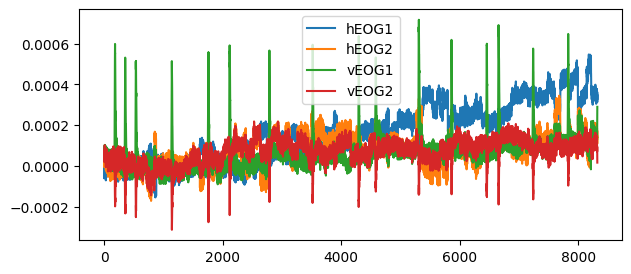

mean:  7.25995348931021e-05
std:  0.00015702547784584084
skew:  [[ 1.13550264  0.99332784  0.84610708 ...  0.40128525  0.22001331
   0.16570041]
 [ 1.70197058  0.60176249  1.87548038 ...  0.55436628  1.16898483
   0.80148154]
 [ 0.57518709  0.77856896  0.77426831 ...  0.29953847  0.19761345
   0.03739925]
 [-0.31427298 -0.28267195 -0.20754376 ... -0.44515172 -0.36865727
  -0.22606339]]
kurtosis:  [[ 4.47438757  3.28465741  2.58873531 ... -0.1673244  -0.83989082
  -0.31102711]
 [12.47562704 10.42081571 11.61601642 ...  4.50768902  5.4810007
   4.70620415]
 [ 0.79611653  1.09192387  1.42341279 ...  0.90176926  1.02202222
   0.71352449]
 [ 0.33230728  0.28720898  0.40914113 ...  0.98369483  1.76732372
   1.04301259]]
me.1absdf:  2.642962281956579e-05
me.2absdf:  4.793585791731982e-05
me.1df:  2.199707354746594e-08
me.2df:  -9.941360555623184e-10
me.negdf:  -2.633888155012256e-05
ro.negdf:  16681.425
num.argmi:  416272
num.argma:  422362


In [19]:
trial_num = 1
eog_feat = extract_EOG_features(subject_id, trial_num)
#pprint.pprint(gsr_feat)

for measure in eog_feat.keys():
    print('%s: ' %(measure),eog_feat[measure])

In [20]:
def extract_EMG_features(subject_id,trial_num):

    trial = trial_num

    feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')

    EMG_path = os.path.join(feats_folder, 's{:02}_EMG.npy'.format(subject_id))
    if os.path.exists(EMG_path):
        print('\nFeatures are already saved.\nSkipping data extraction for Subject {:02}'.format(subject_id))

    print('\nExtracting features for Subject {:02}'.format(subject_id))

    # Load data
    EMG_file_path = os.path.join(npy_folder, 's{:02d}_EMG.npy'.format(subject_id))
    print('Loading preprocessed EMG from .npy file {}\n'.format(EMG_path))
    EMG_data = np.load(EMG_file_path)
    
    len_data = np.shape(EMG_data[trial,:,:])[1]
    print(len_data)
    legend = ['zEMG1','zEMG2','tEMG1', 'tEMG2']
    plt.figure(figsize=(7,3))
    plt.plot(np.arange(0,len_data), EMG_data[trial,0,:])
    plt.plot(np.arange(0,len_data), EMG_data[trial,1,:])
    plt.plot(np.arange(0,len_data), EMG_data[trial,2,:])
    plt.plot(np.arange(0,len_data), EMG_data[trial,3,:])
    plt.legend(labels=legend)
    plt.show()
    
    features = statistics_feature(EMG_data)
    return features


Extracting features for Subject 24
Loading preprocessed EMG from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s24_EMG.npy

8320


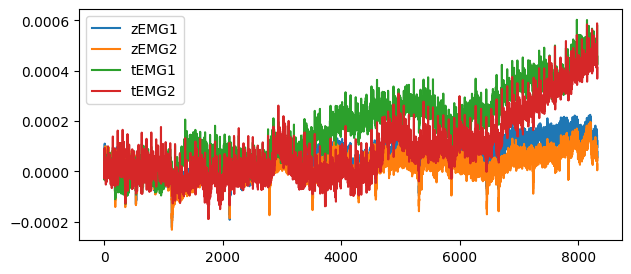

mean:  3.533245081232683e-05
std:  0.000522598005814456
skew:  [[-0.37928025 -0.30636735 -0.10903541 ... -0.94930538 -0.85221181
  -0.8192324 ]
 [ 0.02848042 -0.07484976 -0.13988532 ... -0.69536145 -0.79793655
  -0.55973643]
 [-3.71173766 -3.50300565 -3.74281871 ...  3.16541301  3.11673882
   3.19012602]
 [-1.02913354 -0.75283232 -0.90388981 ... -4.39220681 -4.44284158
  -4.41242009]]
kurtosis:  [[-3.94319802e-01 -5.59242405e-01  4.83079292e-02 ...  1.08876570e+00
   7.57043994e-01  9.09980434e-01]
 [-7.51568167e-01 -6.82297321e-01 -1.53652934e-01 ...  8.22965409e-03
   5.74487094e-01 -2.72130310e-01]
 [ 1.78760262e+01  1.65990940e+01  1.81022746e+01 ...  1.64838223e+01
   1.63610326e+01  1.66344412e+01]
 [ 1.25808563e+01  1.21332284e+01  1.24575207e+01 ...  2.34737656e+01
   2.38027583e+01  2.36183461e+01]]
me.1absdf:  2.7175036043891104e-05
me.2absdf:  4.861201402673252e-05
me.1df:  2.2691820446658245e-08
me.2df:  -1.5695402208306983e-09
me.negdf:  -2.726496501444202e-05
ro.negdf:  1

In [21]:
trial_num = 1
emg_feat = extract_EMG_features(subject_id, trial_num)
#pprint.pprint(gsr_feat)

for measure in emg_feat.keys():
    print('%s: ' %(measure),emg_feat[measure])

### 3. Feature Selection

#### 3.1: combine features

In [55]:
len_HR_feat = len(HR_feat)
print(HR_feat,'\n', len_HR_feat, '\n')

hr_gsr_df = pd.DataFrame.from_dict([HR_feat, gsr_feat], 'columns')
hr_gsr_df.head()


{'bpm': 89.98174071819841, 'ibi': 666.8019480519481, 'sdnn': 36.04995097584653, 'sdsd': 18.895682741562172, 'rmssd': 30.287774575110113, 'pnn20': 0.5223880597014925, 'pnn50': 0.1044776119402985, 'hr_mad': 31.25, 'sd1': 21.34658270380601, 'sd2': 45.248246966229864, 's': 3034.4500374995, 'sd1/sd2': 0.4717659607837981, 'breathingrate': 0.13333333333333333} 
 13 



,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,...,skew,kurtosis,me.1absdf,me.2absdf,me.1df,me.2df,me.negdf,ro.negdf,num.argmi,num.argma
0,89.981741,666.801948,36.049951,18.895683,30.287775,0.522388,0.104478,31.25,21.346583,45.248247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[1.881865710678318, 1.8901293268048964, 1.8593...","[3.4577198515545398, 3.5511356967461314, 3.362...",74.079276,138.619139,0.117037,0.001644,-74.061059,4153.95,107868.0,104653.0


In [56]:
eog_emg_df = pd.DataFrame.from_dict([eog_feat, emg_feat])
eog_emg_df.head()

,mean,std,skew,kurtosis,me.1absdf,me.2absdf,me.1df,me.2df,me.negdf,ro.negdf,num.argmi,num.argma
0,0.000073,0.000157,"[[1.1355026414084566, 0.9933278361097694, 0.84...","[[4.474387566870537, 3.2846574064250795, 2.588...",0.000026,0.000048,2.199707e-08,-9.941361e-10,-0.000026,16681.425,416272,422362
1,0.000035,0.000523,"[[-0.37928025129468385, -0.3063673503113746, -...","[[-0.3943198020087526, -0.5592424046254347, 0....",0.000027,0.000049,2.269182e-08,-1.569540e-09,-0.000027,16569.275,409251,420089


In [115]:
x_train_feats = pd.concat([hr_gsr_df,eog_emg_df])
x_train_feats.head()

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,...,skew,kurtosis,me.1absdf,me.2absdf,me.1df,me.2df,me.negdf,ro.negdf,num.argmi,num.argma
0,89.981741,666.801948,36.049951,18.895683,30.287775,0.522388,0.104478,31.25,21.346583,45.248247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[1.881865710678318, 1.8901293268048964, 1.8593...","[3.4577198515545398, 3.5511356967461314, 3.362...",74.079276,138.619139,1.170366e-01,1.644119e-03,-74.061059,4153.950,107868.0,104653.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[1.1355026414084566, 0.9933278361097694, 0.84...","[[4.474387566870537, 3.2846574064250795, 2.588...",0.000026,0.000048,2.199707e-08,-9.941361e-10,-0.000026,16681.425,416272.0,422362.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[-0.37928025129468385, -0.3063673503113746, -...","[[-0.3943198020087526, -0.5592424046254347, 0....",0.000027,0.000049,2.269182e-08,-1.569540e-09,-0.000027,16569.275,409251.0,420089.0


In [116]:
print(ratings_subj.columns)
# print(ratings_subj.)
y_vad = ratings_subj.iloc[:,4:7] #["Valence", "Arousal", "Dominance"]
# y_vad
print(y_vad.head())
y_train = pd.DataFrame(y_vad)
y_train.head()

Index(['Participant_id', 'Trial', 'Experiment_id', 'Start_time', 'Valence',
       'Arousal', 'Dominance', 'Liking', 'Familiarity'],
      dtype='object')
     Valence  Arousal  Dominance
920     7.03     5.05       7.08
921     4.08     5.99       4.97
922     1.00     8.06       1.97
923     4.03     6.08       7.08
924     3.03     6.06       4.03


,Valence,Arousal,Dominance
920,7.03,5.05,7.08
921,4.08,5.99,4.97
922,1.00,8.06,1.97
923,4.03,6.08,7.08
924,3.03,6.06,4.03


In [117]:
# Combining: HR, GSR, EOG, and EMG. EEG is not working

feature_names = ['HR', 'GSR', 'EOG', 'EMG']
print(np.shape(x_train_feats), np.shape(y_train))
col=feature_names + ['y']
print(col, np.shape(col))

(4, 25) (40, 3)
['HR', 'GSR', 'EOG', 'EMG', 'y'] (5,)


In [ ]:
# Seaborn visualization of features

# df = pd.DataFrame(np.hstack([x_train_feats, y_train[:, np.newaxis]]), columns=col)
# df.head()
# df.describe()

In [ ]:
# sns.pairplot(df, hue='y', diag_kind=None);